In [9]:
# 门控循环单元
import torch
from torch import nn
import d2l.torch as d2l

In [10]:
batch_size,num_steps=32,35
train_iter,vocab = d2l.load_data_time_machine(batch_size,num_steps)

In [11]:
def get_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape,device=device)*0.01
    def three():
        return (normal((num_inputs,num_hiddens)),
                normal((num_hiddens,num_hiddens)),
                torch.zeros(num_hiddens,device=device))
    
    W_xz,W_hz,b_z = three() #更新门参数
    W_xr,W_hr,b_r = three() #重置门参数
    W_xh,W_hh,b_h = three() #候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs,device=device)
    # 附加梯度
    params = [W_xz,W_hz,b_z,W_xr,W_hr,b_r,W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [12]:
# 定义模型
def init_gru_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),)

In [13]:
def gru(inputs,state,params):
    W_xz,W_hz,b_z,W_xr,W_hr,b_r,W_xh,W_hh,b_h,W_hq,b_q = params
    H,=state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz)+b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ( ( R * H ) @ W_hh ) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,)

困惑度 1.0, 66649.8 词元/秒 cpu
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


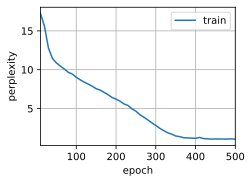

In [14]:
vocab_size,num_hiddens,device = len(vocab),256,d2l.try_gpu()
num_epochs,lr=500,1
model = d2l.RNNModelScratch(len(vocab),num_hiddens,device,get_params,
                            init_gru_state,gru)
d2l.train_ch8(model,train_iter,vocab,lr,num_epochs,device)

困惑度 1.0, 77920.5 词元/秒 cpu
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


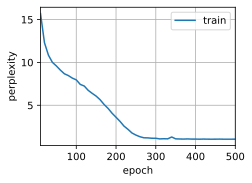

In [15]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs,num_hiddens)
model = d2l.RNNModel(gru_layer,len(vocab))
model = model.to(device)
d2l.train_ch8(model,train_iter,vocab,lr,num_epochs,device)

In [16]:
# 从零开始实现LSTM
batch_size,num_steps = 32,35
train_iter,vocab = d2l.load_data_time_machine(batch_size,num_steps)

In [17]:
def get_lstm_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape,device=device) * 0.01
    def three():
        return (normal((num_inputs,num_hiddens)),
                normal((num_hiddens,num_hiddens)),
                torch.zeros(num_hiddens,device=device))
    W_xi,W_hi,b_i = three() #输入门参数
    W_xf,W_hf,b_f = three() #遗忘门参数
    W_xo,W_ho,b_o = three() #输出门参数
    W_xc,W_hc,b_c = three() #候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs,device=device)
    # 附加梯度
    params = [W_xi,W_hi,b_i,W_xf,W_hf,b_f,W_xo,W_ho,b_o,W_xc,W_hc,
              b_c,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [18]:
# 定义模型：初始化LSTM
def init_lstm_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),
            torch.zeros((batch_size,num_hiddens),device=device))

In [19]:
def lstm(inputs,state,params):
    [W_xi,W_hi,b_i,W_xf,W_hf,b_f,W_xo,W_ho,b_o,W_xc,W_hc,b_c,
     W_hq,b_q] = params
    (H,C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid( (X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid( ( X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid( (X @ W_xo) + ( H @ W_ho) + b_o)
        C_tilda = torch.tanh( (X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = ( H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,C)

困惑度 1.1, 58124.8 词元/秒 cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


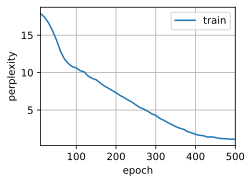

In [20]:
# 训练和预测
vocab_size,num_hiddens,device = len(vocab),256,d2l.try_gpu()
num_epochs,lr=500,1
model = d2l.RNNModelScratch(len(vocab),num_hiddens,device,get_lstm_params,
                            init_lstm_state,lstm)
d2l.train_ch8(model,train_iter,vocab,lr,num_epochs,device)

困惑度 1.0, 45976.8 词元/秒 cpu
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


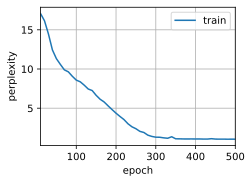

In [21]:
# 使用API训练
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs,num_hiddens)

model = d2l.RNNModel(lstm_layer,len(vocab))
model = model.to(device)
d2l.train_ch8(model,train_iter,vocab,lr,num_epochs,device)


In [22]:
batch_size,num_steps=32,35
train_iter,vocab = d2l.load_data_time_machine(batch_size,num_steps)

In [23]:
vocab_size,num_hiddens,num_layers = len(vocab),256,2
num_inputs  = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs,num_hiddens,num_layers)
model = d2l.RNNModel(lstm_layer,len(vocab))
model = model.to(device)

困惑度 1.0, 27233.8 词元/秒 cpu
time traveller with a slight accession ofcheerfulness really thi
travelleryou can show black is white by argument said filby


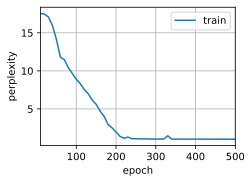

In [24]:
# 训练和预测
num_epochs,lr = 500,2
d2l.train_ch8(model,train_iter,vocab,lr*1.0,num_epochs,device)

困惑度 1.1, 13117.1 词元/秒 cpu
time travellerererererererererererererererererererererererererer
travellerererererererererererererererererererererererererer


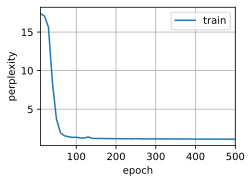

In [25]:
# 双向循环网的错误使用
# 加载数据
batch_size,num_steps,device=32,35,d2l.try_gpu()
train_iter,vocab = d2l.load_data_time_machine(batch_size,num_steps)
# 通过设置bidirective=True来定义双向LSTM模型
vocab_size,num_hiddens,num_layers = len(vocab),256,2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs,num_hiddens,num_layers,bidirectional=True)
model = d2l.RNNModel(lstm_layer,len(vocab))
model = model.to(device)
# 训练模型
num_epochs,lr = 500,1
d2l.train_ch8(model,train_iter,vocab,lr,num_epochs,device)


In [26]:
import os
# 机器翻译与数据集
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    # 载入 英语-法语 数据集
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir,'fra.txt'),'r',
              encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [27]:
def preprocess_nmt(text):
    # 预处理 英语-法语 数据集
    def no_space(char,prev_char):
        return char in set(',.!?') and prev_char !=' '
    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f',' ').replace('\xa0',' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' '+ char if i>0 and no_space(char,text[i-1]) else char
           for i,char in enumerate(text)]
    return ''.join(out)

In [28]:
text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [29]:
def tokenize_nmt(text,num_examples=None):
    # 词元化 英语-法语 数据数据集
    source,target = [],[]
    for i,line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) ==2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source,target

In [30]:
source,target = tokenize_nmt(text)
source[:6],target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

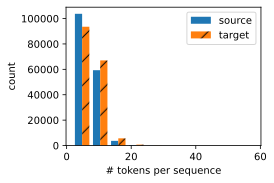

In [31]:
def show_list_len_pair_hist(legend,xlabel,ylabel,xlist,ylist):
    # 绘制列表长度对的直方图
    d2l.set_figsize()
    _,_,patches = d2l.plt.hist(
        [ [len(l) for l in xlist],[len(l) for l in ylist]]
    )
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source','target'],'# tokens per sequence',
                        'count',source,target)

In [32]:
src_vocab = d2l.Vocab(source,min_freq=2,
                      reserved_tokens=['<pad>','<bos>','<eos>'])
len(src_vocab)

10012

In [33]:
def truncate_pad(line,num_steps,padding_token):
    # 截断或填充文本序列
    if len(line) > num_steps:
        return line[:num_steps]  #截断
    return line + [padding_token] * (num_steps - len(line)) #填充


In [34]:
truncate_pad(src_vocab[source[0]],10,src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [35]:
# 将机器翻译的文本序列转换为一个小批量的张量，并计算出每个小批量的有效长度。
def build_array_nmt(lines,vocab,num_steps):
    # 将机器翻译的文本序列转换成小批量
    '''
    lines：一个包含文本序列的列表，每个文本序列代表一句话。
    vocab：一个字典，用于将文本序列中的词转换为对应的索引。
    num_steps：指定每个小批量的长度，超过该长度的序列将被截断，不足该长度的序列将被填充。
    '''
    lines = [vocab[l] for l in lines]
    # 通过列表推导式将lines中的每个文本序列转换成对应的索引序列，并存储在lines列表中。
    lines = [l + [vocab['<eos>']] for l in lines]
    # 为每个文本序列添加一个特殊的结束符'<eos>'，以表示序列的结束。
    array = torch.tensor([truncate_pad(
        l,num_steps,vocab['<pad>']) for l in lines])
    # 调用truncate_pad函数，将每个文本序列进行截断或填充，使其长度为num_steps。
    # 使用torch.tensor将结果转换为张量，并存储在array中。
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum()
    # 计算出每个小批量的有效长度valid_len。
    # 通过检查array中非填充部分的元素（即不等于vocab['<pad>']的元素），
    # 使用torch.sum和type(torch.int32)计算有效长度，并将结果存储在valid_len中。
    return array,valid_len
# 函数返回array和valid_len，分别表示转换后的小批量张量和有效长度。

In [36]:
def load_data_nmt(batch_size,num_steps,num_examples=600):
    # 返回翻译数据集的迭代器和词表
    text = preprocess_nmt(read_data_nmt())
    source,target = tokenize_nmt(text,num_examples)
    src_vocab = d2l.Vocab(
        source,min_freq=2,reserved_tokens=['<pad>','<bos>','<eos>']
    )
    tgt_vocab = d2l.Vocab(
        target,min_freq=2,reserved_tokens=['<pad>','<bos>','<eos>']
    )
    src_array,src_valid_len = build_array_nmt(source,src_vocab,num_steps)
    tgt_array,tgt_valid_len = build_array_nmt(target,tgt_vocab,num_steps)
    data_arrays = (src_array,src_valid_len,tgt_array,tgt_valid_len)
    data_iter = d2l.load_array(data_arrays,batch_size)
    return data_iter,src_vocab,tgt_vocab


In [37]:
train_iter,src_vocab,tgt_vocab = load_data_nmt(batch_size=2,num_steps=8)
for X,X_valid_len,Y,Y_valid_len in train_iter:
    print("X:",X.type(torch.int32))
    print("X的有效长度：",X_valid_len)
    print("Y:",Y.type(torch.int32))
    print("Y的有效长度：",Y_valid_len)
    break

IndexError: Dimension specified as 0 but tensor has no dimensions

9.6.1 编码器

In [38]:
from torch import nn

class Encoder(nn.Module):
    # 编码器-解码器架构的基本编码器接口
    def __init__(self,**kwargs):
        super(Encoder,self).__init__(**kwargs)
    def forward(self,X,*args):
        raise NotImplementedError

In [39]:
class Decoder(nn.Module):
    # 编码器-解码器架构的基本解码器接口
    def __init__(self,**kwargs):
        super(Decoder,self).__init__(**kwargs)
    def init_state(self,enc_outputs,*args):
        raise NotImplementedError
    def forward(self,X,state):
        raise NotImplementedError

In [ ]:
class EncoderDecoder(nn.Module):
    # 编码器-解码器架构的基类
    def __init__(self,encoder,decoder,**kwargs):
        super(EncoderDecoder,self).__init__(**kwargs)